## Introduction

We want to be able to indentify legendary pokemon based on type, stats, and generation. This will be a binary classification problem.

In [241]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [242]:
data = pd.read_csv('Pokemon.csv')

In [243]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [244]:
cpt_rates = pd.read_csv("pkmn_capture_rates.csv")

In [245]:
data = data.merge(cpt_rates, how='left', left_on='#', right_on ='pkmn_number')

In [246]:
data = data.drop(["names", "pkmn_number", "capture_rate"], axis = 1)

In [247]:
# lets standardize the column names
data.columns = [col.lower()
                   .replace(".","") 
                   .replace(" ", "_")
                for col in data.columns]

# how much of the data is legendaries?
data['legendary'].sum() / data.shape[0]

0.0925

## <u>Preprocessing</u>
### Stratified Sampling

Since the positive class (being legendary) is rare, let's use a stratified sampling method

In [248]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=24)
for train_index, test_index in split.split(data, data['legendary']):
    train = data.loc[train_index]
    test = data.loc[test_index]

### Data Cleaning

In [249]:
# removing mega evolutions
train = train[train['name'].apply(lambda col: True if not re.search('\wMega',col) else False)] # "Mega" is typically after a word
test = test[test['name'].apply(lambda col: True if not re.search('\wMega',col) else False)] # "Mega" is typically after a word

In [250]:
# remove useless columns
train = train.drop(['#', 'name'], axis = 1)
test = test.drop(['#', 'name'], axis = 1)

In [251]:
# make the generation into an object type
train['generation'] = train['generation'].astype(str)
test['generation'] = test['generation'].astype(str)

In [252]:
# total, by definition is colinear with other stats
train = train.drop('total', axis = 1)
test = test.drop('total', axis = 1)

### Exploration

Since mega-evolutions are gone, let's do some exploratory analysis.

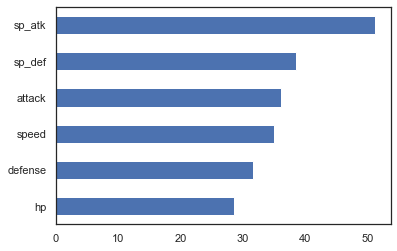

In [253]:
train.pivot_table(index='legendary', values=['hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed'], aggfunc=np.mean) \
     .apply(lambda row: row[True] - row[False], axis=0) \
     .sort_values() \
     .plot.barh()

We see that on average, most legendary pokemon have much higher sp_atk that regular pokemon.

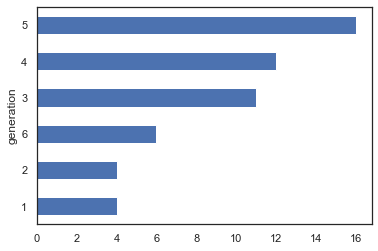

In [254]:
train.pivot_table(index='generation', values=['legendary'], aggfunc=np.sum)\
     .sort_values(by='legendary')\
     .plot.barh(legend=False)

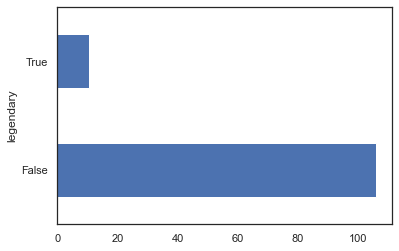

In [255]:
train.pivot_table(index='legendary', values=['capture_rate_clean'], aggfunc=np.mean)\
     .plot.barh(legend=False)

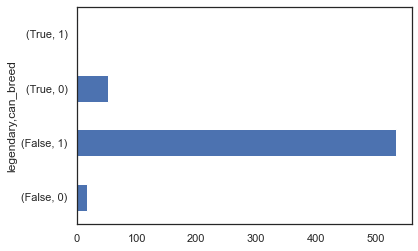

In [256]:
train.pivot_table(index=['legendary','can_breed'], values=['capture_rate_clean'], aggfunc=np.size)\
     .plot.barh(legend=False)

Most legendaries can't breed and most non-legendaries can breed.

### Column Transformation
#### Type Indicator
We want to make sure that the model doesn't care if a type is type1 or type2 if it's the same type. This will also reduce 
34 dummy columns for type to 17.

In [257]:
# get all the unique types
types = set(np.concatenate((train['type_1'].unique(), 
                            train['type_2'].dropna().unique()))) # get all the types in the train and test
types = list(types)

# make a column for each type on the train and test set
for type_ in types:
    dummy_col = type_.lower() + "_ind"
    train[dummy_col] = train.apply(lambda row: 1 if row['type_1'] == type_ or row['type_2'] == type_ else 0, axis = 1)

for type_ in types:
    dummy_col = type_.lower() + "_ind"
    test[dummy_col] = test.apply(lambda row: 1 if row['type_1'] == type_ or row['type_2'] == type_ else 0, axis = 1)
    
# we can drop the type columns now
train = train.drop(['type_1', 'type_2'], axis = 1)
test = test.drop(['type_1', 'type_2'], axis = 1)    

#### One-hot Encoding 

In [258]:
def create_dummies(df, column_name, drop = True):
    
    dummies = pd.get_dummies(df[column_name], prefix = column_name)
    df = pd.concat([df, dummies], axis = 1)
    if drop:
        df = df.drop(column_name, axis = 1)
    return df

In [259]:
train = create_dummies(train, "generation")
test = create_dummies(test, "generation")

Let's see which specific stats legendary pokemon are higher in than regular pokemon.

Legendary typically have much stronger sp_atk than regular pokemon.

In [260]:
def plot_correlation_heatmap(df):
    
    corr = df.corr()
    sns.set(style = 'white')
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (11, 9))
    cmap = sns.diverging_palette(10, 150, as_cmap = True)
    sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
                square= True, linewidth = .5, cbar_kws = {'shrink':.5})
    plt.show()

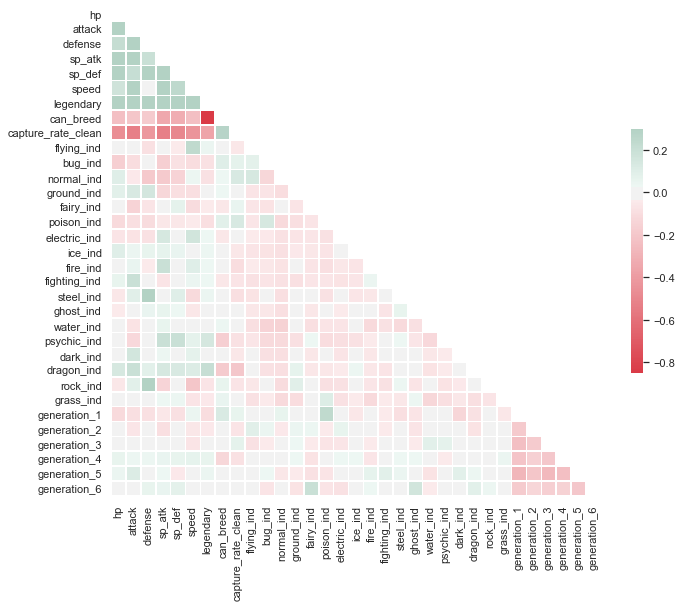

In [261]:
plot_correlation_heatmap(train)

**Insights:**

We see that typically as one type increases, so do the others. The only one that don't predict eachother that well is speed and defense.

Being dragon or psychic is a strong indicator that pokemon might be legendary.

The fighting feature could be deleted since it hardly predicts legendary status and is strongly correlated with the attack feature.

The same could be said about fairy and the sp def stat and just being gen 6

Normal and bug can be taken out too since it's typically not represent with any other type.

We may be able to remove sp atk and defense since they're correlated with other types too.

generations are weak indicators of legendaries, and we saw that they're isn't many legendaries per generation to begin with.

Using the capture rate takes care of pokemon like who have extremely high defenses so it can be misclassified

In [263]:
# based on our insights, let's drop the generation features
train = train.drop(['generation_1', 'generation_2', 'generation_3', 'generation_4', 'generation_5', 'generation_6'], axis=1)
test = test.drop(['generation_1', 'generation_2', 'generation_3', 'generation_4', 'generation_5', 'generation_6'], axis=1)

# getting rid of the generations helped alot

train = train.drop(['fairy_ind', 'rock_ind', 'fighting_ind', 
                    'electric_ind', 'bug_ind', 'normal_ind', 'grass_ind', 'ghost_ind', 'water_ind', 'steel_ind'], axis=1)

test = test.drop(['fairy_ind', 'rock_ind', 'fighting_ind', 
                  'electric_ind', 'bug_ind', 'normal_ind', 'grass_ind', 'ghost_ind', 'water_ind', 'steel_ind'], axis=1)

# getting rid of the types didn't help much from the generations removal
train = train.drop(['dark_ind', 'ice_ind', 'poison_ind', 'flying_ind', 'ground_ind', 'fire_ind'], axis=1)

test = test.drop(['dark_ind', 'ice_ind', 'poison_ind', 'flying_ind', 'ground_ind', 'fire_ind'], axis=1)
# with getting rid of most of the types above, we achieve a R/C curve of 95/78

# turn the above into one drop statement

train = train.drop(['psychic_ind', 'dragon_ind'], axis=1) # adding these don't seem to hurt...

test = test.drop(['psychic_ind', 'dragon_ind'], axis=1)

# how about ONLY capture rate?

train = train.drop(['hp', 'attack'], axis=1)

test = test.drop(['hp', 'attack'], axis=1)

KeyError: "['generation_1' 'generation_2' 'generation_3' 'generation_4'\n 'generation_5' 'generation_6'] not found in axis"

In [264]:
# splitting the features and labels
X_train = train.drop('legendary', axis = 1)
X_test = test.drop('legendary', axis = 1)

y_train = train['legendary'] 
y_test = test['legendary'] 

## <u>Modeling

In [265]:
from sklearn.linear_model import LogisticRegression

In [266]:
lr = LogisticRegression()

In [267]:
lr.fit(X_train, y_train)

LogisticRegression()

In [268]:
preds = lr.predict(X_test)

In [269]:
# Let's take a quick look at the accuracy score, even though it's misleading
from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds)

0.9932885906040269

In [270]:
# we can use this too
lr.score(X_test, y_test) 

0.9932885906040269

### Decision Scores

Since we'll like to maximize the recall and precision of the our model, let's find the decision scores of our model.

In [271]:
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(lr, X_train, y_train, cv = 3,
                             method = 'decision_function')

### Precision-Recall Curve

We decide to use this curve since the positive class (i.e. legendary pokemon) are rare.

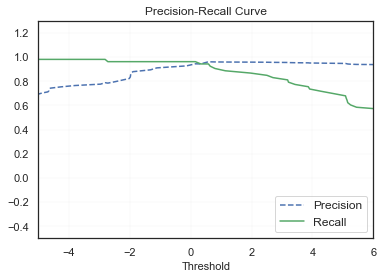

In [272]:
from sklearn.metrics import precision_recall_curve


precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="lower right", fontsize=12)
    plt.xlabel("Threshold", fontsize=11)        
    plt.grid(True, linewidth=.1)                             
    plt.axis([-5, 6, -.5, 1.3])
    plt.title("Precision-Recall Curve", loc="center")
    

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [280]:
# let's see this in a tabular format
names = ["precision", "recall", "thresholds"]
prt_dict = {name:nums for name, nums in zip(names, [precisions[:-1], recalls[:-1], thresholds])}
prt_df = pd.DataFrame(prt_dict)
prt_df[prt_df["recall"].between(.92,.98)]  # this is the recall range we're interested in, based on the curve above.

,precision,recall,thresholds
64,0.784615,0.962264,-2.719776
65,0.796875,0.962264,-2.473624
66,0.822581,0.962264,-2.017445
67,0.836066,0.962264,-1.981768
68,0.864407,0.962264,-1.964976
69,0.879310,0.962264,-1.896145
70,0.894737,0.962264,-1.314822
71,0.910714,0.962264,-1.112062
72,0.927273,0.962264,-0.136130
73,0.944444,0.962264,0.156139


We decide that the threshold of -0.648266 is best since it'll keep the recall around around #####80%, while keeping the precision relatively high. 

#### Testing and Setting the new Threshold

In [283]:
from sklearn.metrics import precision_score, recall_score

new_pred = y_scores >= 0.156138

print(f'precision score: {precision_score(y_train, new_pred)}\n\
   recall score: {recall_score(y_train, new_pred)}')

precision score: 0.9444444444444444
   recall score: 0.9622641509433962


### Test Set

In [284]:
test_preds = lr.decision_function(X_test) >=  0.156138

print(f'precision score: {precision_score(y_test, test_preds)}\n\
   recall score: {recall_score(y_test, test_preds)}')

precision score: 1.0
   recall score: 0.9333333333333333


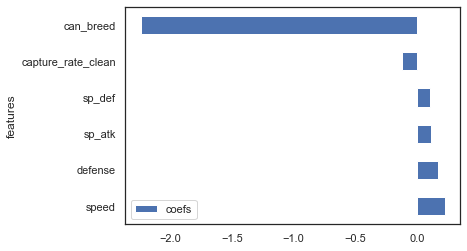

In [285]:
features = list(X_train.columns)
coefs = list(lr.coef_[0])

pd.DataFrame({'features':features,
              'coefs':coefs}).sort_values(by=['coefs'], ascending=False).set_index("features").plot.barh()

### Conclusion

We see that our performed better on the test set than on the training set. However, there's still a lot of volatility. On another run, there's a good chance that our precision/recall on the test would be worse.  Since only about 8% of pokemon are legendary, there's a good chance that many of the legendary pokemon that are outliers will (e.g. have lower stats) fall into one of the sets and not the other.

## Next Time:

see if you can make any actions from the exploration phase especially the correlation map.

see if you can make so that we can see which features predict being legendary the best.

By using the correlation map, we achieve around r/p of 90/79 which is good.

Next let's make a function where you can type in any pokeon name and we can see what the classifier thinks it is.

Maybe we can try using grid search, RCEV to see which features are best to keep.

For git hub, I might just remove the experimentation piece. Else I can make a transformer or a combined dataframe to see which  (in a neat way) to see which pokemon the classfier erroneouly classifies.

## Experimenting

let's make a function that takes in a pokemon name and then runs the model and see if this is a pokemon or not!

In [286]:
def find_legend_status(input_name):
    
    input_name = input_name.lower().capitalize()
    input_index = data[data['name'] == input_name].index[0]
    try:
        score = lr.decision_function(X_train.loc[[input_index],:])
    except KeyError:
        score =  lr.decision_function(X_test.loc[[input_index],:])
    label = score >=-2.907026
    return score, label


In [287]:
find_legend_status("jolteon")

(array([-0.99773711]), array([ True]))

In [288]:
combined = pd.concat([X_train, X_test], axis =0)

combined['pred'] = lr.decision_function(combined) >=-2.907026
x = combined.merge(data, how='inner', left_index=True, right_index=True)\
        .sort_index()\
        .loc[:,['name', 'pred', 'legendary']]
        

In [289]:
x[x['pred'] != x['legendary']]

,name,pred,legendary
146,Jolteon,True,False
412,Metagross,True,False
519,Togekiss,True,False
532,RotomHeat Rotom,True,False
533,RotomWash Rotom,True,False
534,RotomFrost Rotom,True,False
535,RotomFan Rotom,True,False
536,RotomMow Rotom,True,False
696,Hydreigon,True,False
698,Volcarona,True,False
